In [78]:
import numpy as np
import os,mmap
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from librosa.core import load
from scipy.io import wavfile
from intervaltree import IntervalTree
import csv
import pandas as pd

from time import time

from multiprocessing import Pool

root = '../data/'

# When data are still in wav format and csv format

## process_data

In [2]:
folder = 'test_data'
start = time()
for item in tqdm(os.listdir(os.path.join(root,folder))):
    if not item.endswith('.wav'): continue # skip to next file if it is not wav
    uid = item[:-4]
    _, data = wavfile.read(os.path.join(root, folder, item))
    np.save(os.path.join(root, folder, uid), data)
print("Time used = ", time()-start)

100%|██████████| 20/20 [00:01<00:00, 13.55it/s]

Time used =  1.4797403812408447


In [3]:
folder = 'train_data'
start = time()
for item in tqdm(os.listdir(os.path.join(root,folder))):
    if not item.endswith('.wav'): continue # skip to next file if it is not wav
    uid = item[:-4]
    _, data = wavfile.read(os.path.join(root, folder, item))
    np.save(os.path.join(root, folder, uid), data)
print("Time used = ", time()-start)

100%|██████████| 641/641 [02:17<00:00,  4.66it/s]

Time used =  137.56201601028442


## process_labels

In [2]:
trees = dict()
folder = 'test_labels'
for item in tqdm(os.listdir(os.path.join(root, folder))):
    if not item.endswith('.csv'): continue
    uid = item[:-4]
    tree = IntervalTree()
    
    df = pd.read_csv(os.path.join(root, folder, item))
    # Looping event by event
    for label in df.iterrows():
        start_time = label[1]['start_time']
        end_time = label[1]['end_time']
        instrument = label[1]['instrument']
        note = label[1]['note']
        start_beat = label[1]['start_beat']
        end_beat = round(label[1]['end_beat'], 15) # Round to prevent float number precision problem
        note_value = label[1]['note_value']
        tree[start_time:end_time] = (instrument,note,start_beat,end_beat,note_value)
        
    trees[int(uid)] = tree  

100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


In [35]:
trees = dict()
folder = 'train_labels'
for item in tqdm(os.listdir(os.path.join(root, folder))):
    if not item.endswith('.csv'): continue
    uid = item[:-4]
    tree = IntervalTree()
    
    df = pd.read_csv(os.path.join(root, folder, item))
    # Looping event by event
    for label in df.iterrows():
        start_time = label[1]['start_time']
        end_time = label[1]['end_time']
        instrument = label[1]['instrument']
        note = label[1]['note']
        start_beat = label[1]['start_beat']
        end_beat = round(label[1]['end_beat'], 15) # Round to prevent float number precision problem
        note_value = label[1]['note_value']
        tree[start_time:end_time] = (instrument,note,start_beat,end_beat,note_value)
        
    trees[int(uid)] = tree  

100%|██████████| 321/321 [04:08<00:00,  2.26it/s]


# When data are processed as npy and trees

## def__enter__

In [578]:
# test
data_folder = 'train_data'
labels_folder = 'train_labels'
data_path = os.path.join(root, data_folder)
labels_path = os.path.join(root, labels_folder, 'test_tree.pckl')

records = dict()
open_files = []

## Fiilling up the dictionary with info

### mmap versin

In [579]:
sz_float = 4
start = time()
for record in os.listdir(data_path):
    if not record.endswith('npy'): continue
    fd = os.open(os.path.join(data_path, record), os.O_RDONLY)
    buff = mmap.mmap(fd, 0, mmap.MAP_SHARED, mmap.PROT_READ)
    records[int(record[:-4])] = (buff, len(buff)/sz_float)
    open_files.append(fd)
        # (songid, file size)
print("time used = ", time()-start)

time used =  0.03847837448120117


### Non mmap

In [580]:
sz_float = 4
start = time()
for record in os.listdir(data_path):
    if not record.endswith('npy'): continue
    with open(os.path.join(data_path, record)) as f:
        records[int(record[:-4])] = (os.path.join(data_path, record), os.fstat(f.fileno()).st_size/sz_float)
        # (songid, file size)
print("time used = ", time()-start)

time used =  0.01887059211730957


In [583]:
len(records)

320

## def access

In [402]:
scale = 1
epsilon = 10e-8 # fudge factor for normalization
window = 163840

In [403]:
with open(labels_path,'rb') as f:
    labels = pickle.load(f) # getting data from tree

In [404]:
rec_ids = list(labels.keys())
rec_id = rec_ids[np.random.randint(0,len(rec_ids))] # generating random id for training

In [405]:
fid, _ = records[rec_id]

In [534]:
s=100

In [535]:
from IPython.display import Audio

## Method 1 fromfile

In [ ]:
with open(fid, 'rb') as f:
    f.seek(s*sz_float, os.SEEK_SET)
    x1 = np.fromfile(f, dtype=np.float32, count=int(scale*window))

## Method 2 np.load

In [545]:
x2 = np.load(fid)
x2 = x2[s: s+window]

In [546]:
x2.shape

(163840,)

In [548]:
xp = np.arange(window,dtype=np.float32)

In [571]:
xp

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.63837e+05,
       1.63838e+05, 1.63839e+05], dtype=float32)

In [572]:
np.arange(len(x2),dtype=np.float32)

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.63837e+05,
       1.63838e+05, 1.63839e+05], dtype=float32)

In [573]:
xp

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.63837e+05,
       1.63838e+05, 1.63839e+05], dtype=float32)

In [574]:
x = np.interp(2*xp,
              np.arange(len(x2),dtype=np.float32),
              x2).astype(np.float32)

In [567]:
Audio(x2, rate=44100)

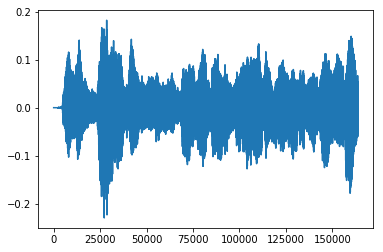

In [568]:
plt.plot(x2)

In [569]:
Audio(x, rate=44100)

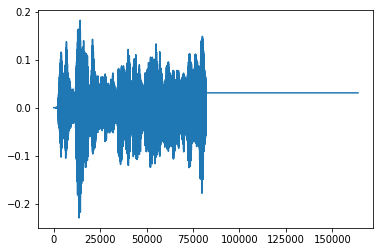

In [575]:
plt.plot(x)

In [510]:
Audio(x1, rate=44100)

In [511]:
Audio(x2, rate=44100)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

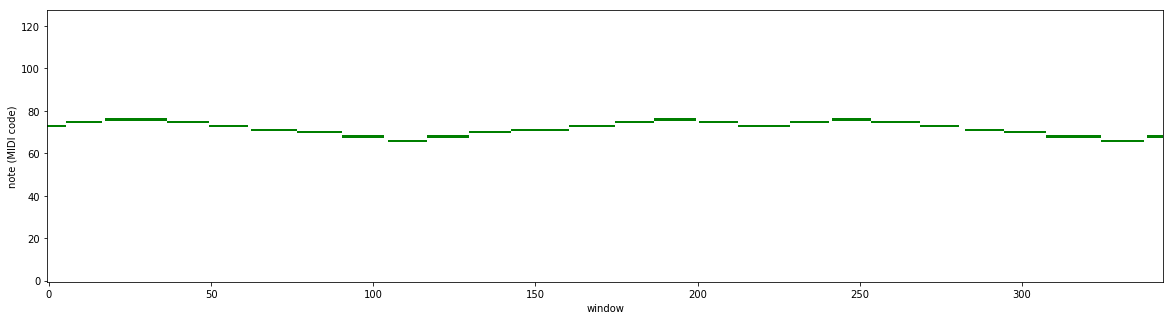

In [512]:
visualize_labels(labels[2191], s, seconds=4)

# Visualize labels

In [431]:
def visualize_labels(Y, offset, seconds=30, fs = 44100, stride = 512):            
    wps = fs/float(stride)               # calculate windows/second
    Yvec = np.zeros((int(seconds*wps),128))   # 128 distinct note labels
#     colors = {1 : .33}
##### To do #####
# make 1 instrument 1 color
#################

    for window in range(Yvec.shape[0]):
        labels = Y[offset+window*stride]
        for label in labels:
            Yvec[window,label.data[1]] = 1

    fig = plt.figure(figsize=(20,5))
    plt.imshow(Yvec.T,aspect='auto',cmap='ocean_r')
    plt.gca().invert_yaxis()
    fig.axes[0].set_xlabel('window')
    fig.axes[0].set_ylabel('note (MIDI code)')
#     plt.close()
    
    return Yvec

In [36]:
with open('../data/train_labels/train_tree.pckl', 'rb') as f:
    ori_trees = pickle.load(f)

In [38]:
for idx in trees:
    Y1 = trees[idx]
    Y2 = ori_trees[idx]
    
    Y1_vis = visualize_labels(Y1)
    Y2_vis = visualize_labels(Y2)
    
    print(np.array_equal(Y1_vis, Y2_vis))


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
